In [1]:
import numpy as np
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import pandas as pd
import plotly_express as px

from PIL import Image
from nltk.corpus import stopwords
import nltk
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
def iter_pd(df):
    for val in df.columns:
        yield val
    for row in df.to_numpy():
        for val in row:
            if pd.isna(val):
                yield ""
            else:
                yield val

def pandas_to_sheets(pandas_df, sheet, clear = True):
    # Updates all values in a workbook to match a pandas dataframe
    if clear:
        sheet.clear()
    (row, col) = pandas_df.shape
    cells = sheet.range("A1:{}".format(gspread.utils.rowcol_to_a1(row + 1, col)))
    for cell, val in zip(cells, iter_pd(pandas_df)):
        cell.value = val
    sheet.update_cells(cells)

def open_ws(sheet, ws_name):
    scope = ['https://spreadsheets.google.com/feeds',
            'https://www.googleapis.com/auth/drive']

    credentials = ServiceAccountCredentials.from_json_keyfile_name(
                                        'google-credentials.json', scope) # Your json file here

    gc = gspread.authorize(credentials)

    ws = gc.open(sheet).worksheet(ws_name)

    return ws

def read_ws_data(ws):

    data = ws.get_all_values()
    headers = data.pop(0)

    df = pd.DataFrame(data, columns=headers)

    return df

In [3]:
def limpieza_string(string):
    string=string.replace("."," ")
    string=string.replace(","," ")
    string=string.replace(";"," ")
    string=string.replace("?"," ")
    string=string.replace("¿"," ")
    string=string.replace("!"," ")
    string=string.replace("¡"," ")
    string=string.replace("\n"," ")
    string=string.replace("  "," ")
    string=string.replace("  "," ")
    string=string.replace("  "," ")
    string=string.replace("  "," ")
    string=string.replace('"'," ")   
    string=string.replace('('," ")  
    string=string.replace(')'," ")  
    string=string.replace(':'," ") 
    string=string.replace('-'," ") 
    string=string.replace('/'," ") 
    
    return string

In [254]:
df = read_ws_data(open_ws("Caso Atlas Bank - BD Feedback de Clientes", "Feedback"))
df

,Fecha,Pais,Dispositivo,Browser,Rank,Comentario
0,8/8/2019,Peru,phone,Chrome Mobile 76.0.3809,1,No consigo lo que deseo. No consigo agendar un...
1,8/8/2019,Peru,desktop,Chrome 76.0.3809,1,
2,8/9/2019,Peru,phone,Chrome Mobile 42.0.2311,1,
3,8/9/2019,Peru,desktop,Chrome 75.0.3770,1,
4,8/9/2019,Peru,phone,Chrome Mobile 75.0.3770,1,No se como registrarme para mi clave
...,...,...,...,...,...,...
11045,2019-09-03 14:39:59,Peru,phone,Samsung Internet 9.4,5,Muy bueno...!!!
11046,2019-09-02 19:43:06,Peru,phone,Mobile Safari 12.0,5,
11047,2019-09-02 16:24:04,Peru,phone,Chrome Mobile 76.0.3809,5,buena
11048,2019-09-02 14:13:51,Peru,phone,Chrome Mobile 64.0.3282,5,


In [255]:
df["Fecha"] = pd.to_datetime(df.Fecha)
df["Fecha"] = df["Fecha"]
df["Fecha_clean"] = df.Fecha.astype(str).str[:10]
df["Fecha_clean"] = df["Fecha_clean"].astype(str)
df["counter"] = 1
df["Comentario_clean"] = df["Comentario"].fillna("").apply(lambda x: limpieza_string(x).lower())
df["Comentario_space"] = df["Comentario_clean"].apply(lambda x: x+" " if x!="" else "")
df["Rank_text"] = df["Rank"].replace({"1":"Uno", "2":"Dos", "3":"Tres", "4":"Cuatro", "5":"Cinco"})
df["Rank"] = df["Rank"].astype(float)
df["Browser_clean"] = df.Browser.apply(lambda x: x[:x.rfind(" ")])
df["Comentada"] = df.Comentario_clean.apply(lambda x: 0 if x=="" else 1)

df["id_concat"] = df["Fecha"].astype(str) + df["Comentario"] + df["Browser"] + df["Rank_text"]
df = df[(~df.id_concat.duplicated()) | (df['Comentario'].isna()) | (df["Comentario"]=="")].reset_index(drop=True)
df["id"] = df.index
df

,Fecha,Pais,Dispositivo,Browser,Rank,Comentario,Fecha_clean,counter,Comentario_clean,Comentario_space,Rank_text,Browser_clean,Comentada,id_concat,id
0,2019-08-08 00:00:00,Peru,phone,Chrome Mobile 76.0.3809,1.0,No consigo lo que deseo. No consigo agendar un...,2019-08-08,1,no consigo lo que deseo no consigo agendar una...,no consigo lo que deseo no consigo agendar una...,Uno,Chrome Mobile,1,2019-08-08 00:00:00No consigo lo que deseo. No...,0
1,2019-08-08 00:00:00,Peru,desktop,Chrome 76.0.3809,1.0,,2019-08-08,1,,,Uno,Chrome,0,2019-08-08 00:00:00Chrome 76.0.3809Uno,1
2,2019-08-09 00:00:00,Peru,phone,Chrome Mobile 42.0.2311,1.0,,2019-08-09,1,,,Uno,Chrome Mobile,0,2019-08-09 00:00:00Chrome Mobile 42.0.2311Uno,2
3,2019-08-09 00:00:00,Peru,desktop,Chrome 75.0.3770,1.0,,2019-08-09,1,,,Uno,Chrome,0,2019-08-09 00:00:00Chrome 75.0.3770Uno,3
4,2019-08-09 00:00:00,Peru,phone,Chrome Mobile 75.0.3770,1.0,No se como registrarme para mi clave,2019-08-09,1,no se como registrarme para mi clave,no se como registrarme para mi clave,Uno,Chrome Mobile,1,2019-08-09 00:00:00No se como registrarme para...,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9288,2019-09-03 17:48:14,Peru,phone,Chrome Mobile 75.0.3770,5.0,,2019-09-03,1,,,Cinco,Chrome Mobile,0,2019-09-03 17:48:14Chrome Mobile 75.0.3770Cinco,9288
9289,2019-09-03 16:18:53,Peru,phone,Chrome Mobile 75.0.3770,5.0,,2019-09-03,1,,,Cinco,Chrome Mobile,0,2019-09-03 16:18:53Chrome Mobile 75.0.3770Cinco,9289
9290,2019-09-02 19:43:06,Peru,phone,Mobile Safari 12.0,5.0,,2019-09-02,1,,,Cinco,Mobile Safari,0,2019-09-02 19:43:06Mobile Safari 12.0Cinco,9290
9291,2019-09-02 14:13:51,Peru,phone,Chrome Mobile 64.0.3282,5.0,,2019-09-02,1,,,Cinco,Chrome Mobile,0,2019-09-02 14:13:51Chrome Mobile 64.0.3282Cinco,9291


In [256]:
df_daily = df[["Fecha_clean", "counter"]].groupby("Fecha_clean", as_index=False).sum()
df_daily = df_daily.merge(df[["Fecha_clean", "Comentario_space"]].groupby("Fecha_clean", as_index=False).sum(), on="Fecha_clean")
df_daily = df_daily.merge(df[["Fecha_clean", "Rank"]].groupby("Fecha_clean", as_index=False).mean(), on="Fecha_clean")
df_daily["Rank"] = df_daily["Rank"].round(4)
df_daily

,Fecha_clean,counter,Comentario_space,Rank
0,2019-08-08,31,no consigo lo que deseo no consigo agendar una...,3.1290
1,2019-08-09,25,no se como registrarme para mi clave muchas ve...,3.0000
2,2019-08-10,33,sale otro idioma 😡 no puedo bloquear mi tarjet...,2.4545
3,2019-08-11,35,quiero hacer una trransferencia a mi hija a ot...,2.9143
4,2019-08-12,42,quiero henerar clave y no puedo q pasos debo ...,3.4286
...,...,...,...,...
200,2020-02-24,62,la pagina de banca por internet cada vez que...,3.8065
201,2020-02-25,39,me rechaza mi numero de tarjeta apezar q esta ...,3.2564
202,2020-02-26,43,quiero cambiar la contraseña y no me deja no p...,2.9535
203,2020-02-27,22,hasta el momento nunca puedo ingresar por el a...,2.7727


In [257]:
print(df_daily.counter.mean())
px.line(df_daily, x="Fecha_clean", y="counter", title="Feedbacks diarios")

45.33170731707317


In [258]:
print(df_daily.Rank.mean())
px.line(df_daily, x="Fecha_clean", y="Rank", title="Ranking promedio")

3.04181512195122


In [259]:
df_pais = df[["Pais", "counter"]].groupby("Pais", as_index=False).sum()
df_pais = df_pais.merge(df[["Pais", "Comentario_space"]].groupby("Pais", as_index=False).sum(), on="Pais")
df_pais = df_pais.merge(df[["Pais", "Rank"]].groupby("Pais", as_index=False).mean(), on="Pais")
df_pais["Rank"] = df_pais["Rank"].round(4)
df_pais

,Pais,counter,Comentario_space,Rank
0,Argentina,7,para finalizar la creación de la clave digital...,2.4286
1,Australia,2,,2.0000
2,Bolivia,21,wow,2.2381
3,Brazil,10,,3.0000
4,Canada,6,tengo serios problemas desde que han cambiado ...,2.5000
5,Chile,23,malo muy malo mala estoy tratando de llamar a ...,2.4783
6,Colombia,9,llevo escribiendo resto estoy em colombia y no...,3.5556
7,Dominican Republic,1,sexe,1.0000
8,Ecuador,2,,2.0000
9,Ethiopia,2,estoy en europa ahora y mi tarjeta de credito ...,2.0000


In [260]:
print(df_pais.counter.mean())
px.line(df_pais, x="Pais", y="counter", title="Feedbacks diarios")

357.4230769230769


In [261]:
print(df_pais.Rank.mean())
px.line(df_pais, x="Pais", y="Rank", title="Ranking promedio")

2.4274923076923076


In [262]:
df_browser = df[["Browser_clean", "counter"]].groupby("Browser_clean", as_index=False).sum()
df_browser = df_browser.merge(df[["Browser_clean", "Comentario_space"]].groupby("Browser_clean", as_index=False).sum(), on="Browser_clean")
df_browser = df_browser.merge(df[["Browser_clean", "Rank"]].groupby("Browser_clean", as_index=False).mean(), on="Browser_clean")
df_browser["Rank"] = df_browser["Rank"].round(4)
df_browser

,Browser_clean,counter,Comentario_space,Rank
0,Android,18,,3.4444
1,Chrome,1820,no puedo bloquear mi tarjeta mediante web l a...,2.6187
2,Chrome Mobile,5588,no consigo lo que deseo no consigo agendar una...,3.1063
3,Chrome Mobile WebView,99,muy mala más o menos porque no me da una resp...,3.7071
4,Chrome Mobile iOS,127,no pasa nada no puedo obtener mi clsve no encu...,2.8583
5,Edge,56,la banca por internet es un asco la versión ...,2.0536
6,Facebook,539,no respondes porque lo responden nunca su can...,3.8126
7,Firefox,63,no puedo entrar a banca por internet hay que ...,2.6190
8,Firefox Mobile,1,muy mala,1.0000
9,IE,67,no puedo ingresar sale una cara y quiere que a...,1.9701


In [263]:
print(df_browser.counter.mean())
px.line(df_browser, x="Browser_clean", y="counter", title="Feedbacks diarios")

546.6470588235294


In [264]:
print(df_browser.Rank.mean())
px.line(df_browser, x="Browser_clean", y="Rank", title="Ranking promedio")

2.944376470588235


In [265]:
df_dispositivo = df[["Dispositivo", "counter"]].groupby("Dispositivo", as_index=False).sum()
df_dispositivo = df_dispositivo.merge(df[["Dispositivo", "Comentario_space"]].groupby("Dispositivo", as_index=False).sum(), on="Dispositivo")
df_dispositivo = df_dispositivo.merge(df[["Dispositivo", "Rank"]].groupby("Dispositivo", as_index=False).mean(), on="Dispositivo")
df_dispositivo["Rank"] = df_dispositivo["Rank"].round(4)
df_dispositivo

,Dispositivo,counter,Comentario_space,Rank
0,desktop,2038,no puedo bloquear mi tarjeta mediante web l a...,2.5775
1,phone,7177,no consigo lo que deseo no consigo agendar una...,3.1719
2,tablet,78,horrible no se conecta mejor es el bbva no pue...,2.7179


In [266]:
print(df_dispositivo.counter.mean())
px.line(df_dispositivo, x="Dispositivo", y="counter", title="Feedbacks diarios")

3097.6666666666665


In [267]:
print(df_dispositivo.Rank.mean())
px.line(df_dispositivo, x="Dispositivo", y="Rank", title="Ranking promedio")

2.822433333333333


In [268]:
df_rank = df[["Rank_text", "counter"]].groupby("Rank_text", as_index=False).sum()
df_rank = df_rank.merge(df[["Rank_text", "Comentario_space"]].groupby("Rank_text", as_index=False).sum(), on="Rank_text")
df_rank = df_rank.merge(df[["Rank_text", "Rank"]].groupby("Rank_text", as_index=False).mean(), on="Rank_text")
df_rank["Rank"] = df_rank["Rank"].round(4)
df_rank

,Rank_text,counter,Comentario_space,Rank
0,Cinco,1844,bueno u rápido excelente el servicio pero el...,5.0
1,Cuatro,2439,me parecio concreto e interactivo me gusta pk ...,4.0
2,Dos,1150,no puedo encontrar como generar mi clave de 4 ...,2.0
3,Tres,1547,amigo como puedo conseguir mi clave de interne...,3.0
4,Uno,2313,no consigo lo que deseo no consigo agendar una...,1.0


In [269]:
print(df_rank.counter.mean())
px.line(df_rank, x="Rank_text", y="counter", title="Feedbacks diarios")

1858.6


In [270]:
print(df_rank.Rank.mean())
px.line(df_rank, x="Rank_text", y="Rank", title="Ranking promedio")

3.0


In [271]:
from pysentimiento import create_analyzer
analyzer = create_analyzer(task="sentiment", lang="es")

loading configuration file https://huggingface.co/pysentimiento/robertuito-sentiment-analysis/resolve/main/config.json from cache at C:\Users\JTorrejon/.cache\huggingface\transformers\034fd09e9530137fb6e6c042529972a92619fb02df8b40e7a4cfc50090943c46.98e658c5b8878c67807e3287b07db9608dbd08a5b69ce09979c447190bbe8077
Model config RobertaConfig {
  "_name_or_path": "pysentimiento/robertuito-sentiment-analysis",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "NEG",
    "1": "NEU",
    "2": "POS"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "NEG": 0,
    "NEU": 1,
    "POS": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,

In [272]:
def sentiment(x):
    if x=="": return [np.nan, np.nan, np.nan, np.nan]
    else:
        sent = analyzer.predict(x)
        return [sent.output, sent.probas["POS"], sent.probas["NEU"], sent.probas["NEG"]]

df[["Comentario_SENT", "Comentario_POS", "Comentario_NEU", "Comentario_NEG"]] = df.apply(lambda x: sentiment(x["Comentario_clean"]), axis=1, result_type="expand")
df

,Fecha,Pais,Dispositivo,Browser,Rank,Comentario,Fecha_clean,counter,Comentario_clean,Comentario_space,Rank_text,Browser_clean,Comentada,id_concat,id,Comentario_SENT,Comentario_POS,Comentario_NEU,Comentario_NEG
0,2019-08-08 00:00:00,Peru,phone,Chrome Mobile 76.0.3809,1.0,No consigo lo que deseo. No consigo agendar un...,2019-08-08,1,no consigo lo que deseo no consigo agendar una...,no consigo lo que deseo no consigo agendar una...,Uno,Chrome Mobile,1,2019-08-08 00:00:00No consigo lo que deseo. No...,0,NEG,0.000645,0.015267,0.984088
1,2019-08-08 00:00:00,Peru,desktop,Chrome 76.0.3809,1.0,,2019-08-08,1,,,Uno,Chrome,0,2019-08-08 00:00:00Chrome 76.0.3809Uno,1,NaN,NaN,NaN,NaN
2,2019-08-09 00:00:00,Peru,phone,Chrome Mobile 42.0.2311,1.0,,2019-08-09,1,,,Uno,Chrome Mobile,0,2019-08-09 00:00:00Chrome Mobile 42.0.2311Uno,2,NaN,NaN,NaN,NaN
3,2019-08-09 00:00:00,Peru,desktop,Chrome 75.0.3770,1.0,,2019-08-09,1,,,Uno,Chrome,0,2019-08-09 00:00:00Chrome 75.0.3770Uno,3,NaN,NaN,NaN,NaN
4,2019-08-09 00:00:00,Peru,phone,Chrome Mobile 75.0.3770,1.0,No se como registrarme para mi clave,2019-08-09,1,no se como registrarme para mi clave,no se como registrarme para mi clave,Uno,Chrome Mobile,1,2019-08-09 00:00:00No se como registrarme para...,4,NEU,0.001449,0.606674,0.391877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9288,2019-09-03 17:48:14,Peru,phone,Chrome Mobile 75.0.3770,5.0,,2019-09-03,1,,,Cinco,Chrome Mobile,0,2019-09-03 17:48:14Chrome Mobile 75.0.3770Cinco,9288,NaN,NaN,NaN,NaN
9289,2019-09-03 16:18:53,Peru,phone,Chrome Mobile 75.0.3770,5.0,,2019-09-03,1,,,Cinco,Chrome Mobile,0,2019-09-03 16:18:53Chrome Mobile 75.0.3770Cinco,9289,NaN,NaN,NaN,NaN
9290,2019-09-02 19:43:06,Peru,phone,Mobile Safari 12.0,5.0,,2019-09-02,1,,,Cinco,Mobile Safari,0,2019-09-02 19:43:06Mobile Safari 12.0Cinco,9290,NaN,NaN,NaN,NaN
9291,2019-09-02 14:13:51,Peru,phone,Chrome Mobile 64.0.3282,5.0,,2019-09-02,1,,,Cinco,Chrome Mobile,0,2019-09-02 14:13:51Chrome Mobile 64.0.3282Cinco,9291,NaN,NaN,NaN,NaN


In [273]:
df["Comentario_SENT"].value_counts(), df[["Comentario_POS", "Comentario_NEU", "Comentario_NEG"]].mean()

(NEG    820
 NEU    660
 POS    273
 Name: Comentario_SENT, dtype: int64,
 Comentario_POS    0.182189
 Comentario_NEU    0.332938
 Comentario_NEG    0.484873
 dtype: float64)

Rank:  1.0
 
Rank:  2.0
 
Rank:  3.0
 
Rank:  4.0
 
Rank:  5.0
 


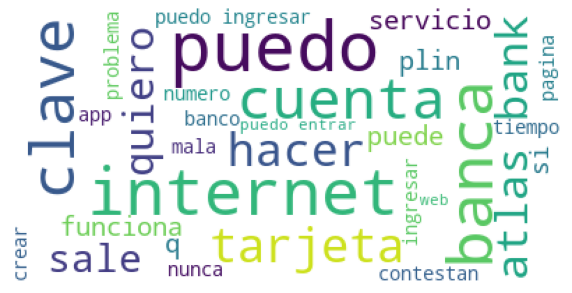

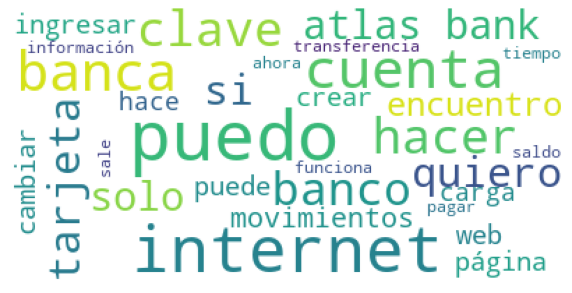

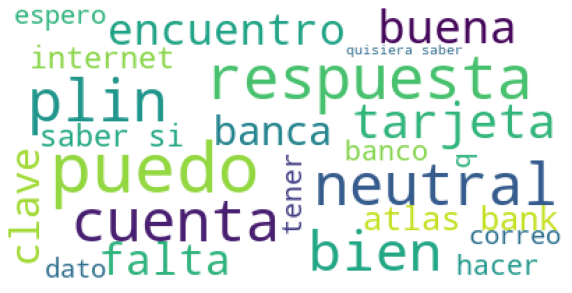

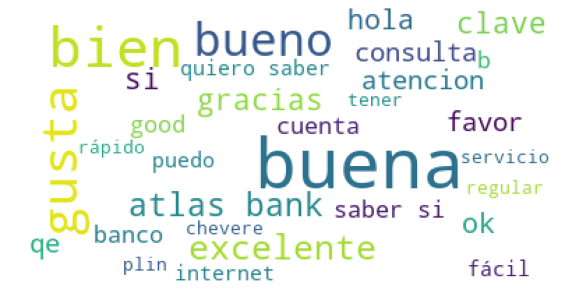

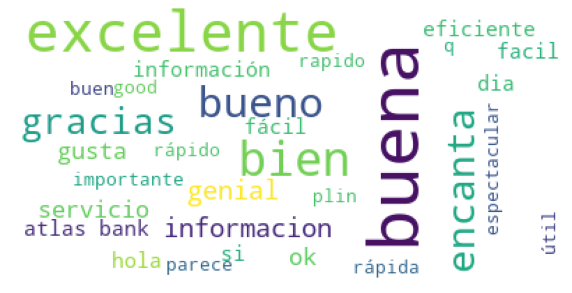

In [274]:
sw = set(stopwords.words("spanish"))
sw.update(["."," "]) # <<<Podemos agregar más cosas aquí

df_comentada = df[df["Comentario_clean"]!=""]
for i in df_comentada["Rank"].unique():
    print("Rank: ", i)
    text = " ".join(str(t) for t in df_comentada[df_comentada["Rank"]==i]["Comentario_clean"].values)

    # Create the WordCloud Object
    wordcloud = WordCloud(stopwords=sw, background_color="white", 
                              mode="RGBA", max_words=30,
                              max_font_size=50, min_font_size=10).generate(text)

    plt.figure(figsize=[10,10])
    plt.imshow(wordcloud)
    plt.axis("off")
    print(" ")

Rank:  NEG
 
Rank:  NEU
 
Rank:  POS
 


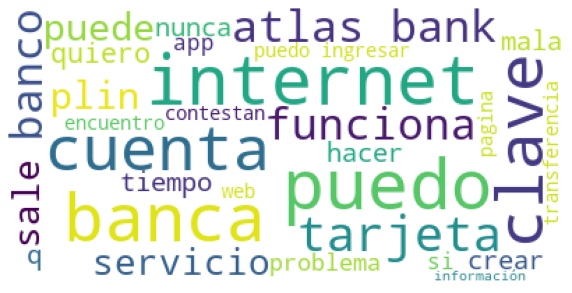

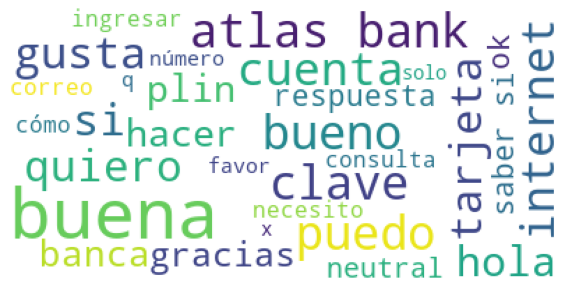

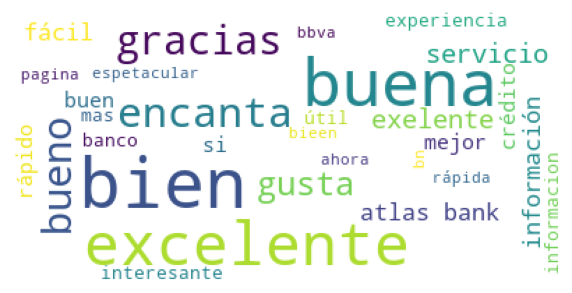

In [275]:
for i in df_comentada["Comentario_SENT"].unique():
    print("Rank: ", i)
    text = " ".join(str(t) for t in df_comentada[df_comentada["Comentario_SENT"]==i]["Comentario_clean"].values)

    # Create the WordCloud Object
    wordcloud = WordCloud(stopwords=sw, background_color="white", 
                              mode="RGBA", max_words=30,
                              max_font_size=50, min_font_size=10).generate(text)

    plt.figure(figsize=[10,10])
    plt.imshow(wordcloud)
    plt.axis("off")
    print(" ")

In [276]:
df_daily[["Comentario_SENT", "Comentario_POS", "Comentario_NEU", "Comentario_NEG"]] = df_daily.apply(lambda x: sentiment(x["Comentario_space"]), axis=1, result_type="expand")

df_daily["Comentario_SENT"].value_counts(), df_daily[["Comentario_POS", "Comentario_NEU", "Comentario_NEG"]].mean()

(NEG    158
 NEU     30
 POS     14
 Name: Comentario_SENT, dtype: int64,
 Comentario_POS    0.065289
 Comentario_NEU    0.162767
 Comentario_NEG    0.771944
 dtype: float64)

In [277]:
df_daily[["Rank", "Comentario_POS"]].corr()

,Rank,Comentario_POS
Rank,1.000000,0.363869
Comentario_POS,0.363869,1.000000


Comentario_SENT:  NEG
 
Comentario_SENT:  NEU
 
Comentario_SENT:  POS
 


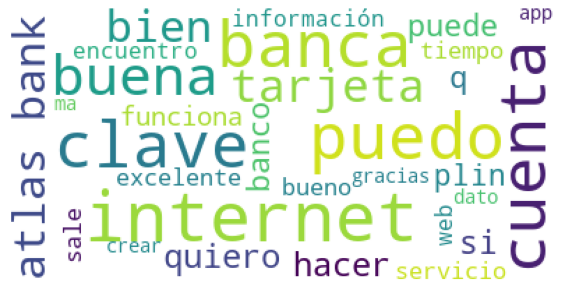

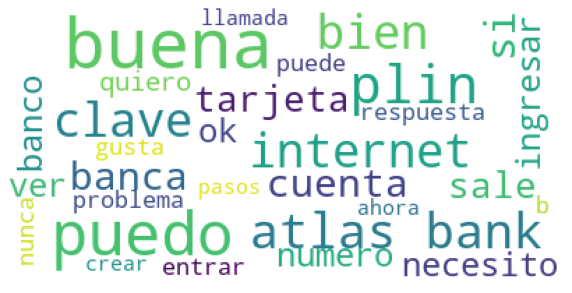

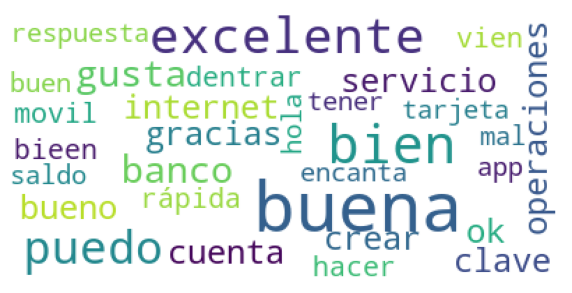

In [278]:
df_daily_comentada = df_daily[df_daily["Comentario_space"]!=""]

for i in df_daily_comentada["Comentario_SENT"].unique():
    print("Comentario_SENT: ", i)
    text = " ".join(str(t) for t in df_daily_comentada[df_daily_comentada["Comentario_SENT"]==i]["Comentario_space"].values)

    # Create the WordCloud Object
    wordcloud = WordCloud(stopwords=sw, background_color="white", 
                              mode="RGBA", max_words=30,
                              max_font_size=50, min_font_size=10).generate(text)

    plt.figure(figsize=[10,10])
    plt.imshow(wordcloud)
    plt.axis("off")
    print(" ")

In [279]:
def df_contains_word(df, col, w):
    return df[(df[col].str.contains(f" {w} ")) | (df[col].str.endswith(f" {w}")) | (df[col].str.startswith(f"{w} "))]

In [280]:
all_w = [x for x in list(set(df["Comentario_space"].values.sum().split())) if x not in sw]
df_all_w = pd.DataFrame()

cat_columns = ["Fecha_clean", "Pais", "Dispositivo", "Browser_clean", "Rank_text", "Comentario_SENT"]
val_columns = ["Rank", "Comentario_POS", "Comentario_NEU", "Comentario_NEG"]

for w in all_w:
    #print(w)
    df_w = df_contains_word(df, "Comentario_clean", w)
    df_w["word"] = w
    df_all_w = pd.concat([df_all_w, df_w])
    #print(len(df_w))
    #df_w_temp = df_w[cat_columns+["counter"]].groupby(cat_columns, as_index=False).sum()
    #df_w_temp = df_w_temp.merge(df_w[cat_columns+["Comentario_space"]].groupby(cat_columns, as_index=False).sum(), on=cat_columns, how="outer")
    #df_w_temp = df_w_temp.merge(df_w[cat_columns+val_columns].groupby(cat_columns, as_index=False).mean(), on=cat_columns, how="outer")
    #df_w_temp["word"] = w
    #print(df_w_temp)
    #df_all_w = pd.concat([df_all_w, df_w_temp])
    
df_all_w.reset_index(drop=True, inplace=True)
df_all_w

C:\Users\JTORRE~1\AppData\Local\Temp/ipykernel_11996/876476870.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Fecha,Pais,Dispositivo,Browser,Rank,Comentario,Fecha_clean,counter,Comentario_clean,Comentario_space,Rank_text,Browser_clean,Comentada,id_concat,id,Comentario_SENT,Comentario_POS,Comentario_NEU,Comentario_NEG,word
0,2019-12-04 16:19:13,Peru,phone,Chrome Mobile 78.0.3904,1.0,Me molesta porque no tiene solución para un pr...,2019-12-04,1,me molesta porque no tiene solución para un pr...,me molesta porque no tiene solución para un pr...,Uno,Chrome Mobile,1,2019-12-04 16:19:13Me molesta porque no tiene ...,976,NEG,0.000284,0.002204,0.997512,cache
1,2020-02-13 03:41:11,Chile,desktop,Chrome 79.0.3945,1.0,"no puedo ingresar a la pagina, al parecer olvi...",2020-02-13,1,no puedo ingresar a la pagina al parecer olvid...,no puedo ingresar a la pagina al parecer olvid...,Uno,Chrome,1,2020-02-13 03:41:11no puedo ingresar a la pagi...,527,NEU,0.002116,0.900802,0.097082,parecer
2,2019-11-07 20:40:22,Canada,desktop,Chrome 78.0.3904,1.0,Tengo serios problemas desde que han cambiado ...,2019-11-07,1,tengo serios problemas desde que han cambiado ...,tengo serios problemas desde que han cambiado ...,Uno,Chrome,1,2019-11-07 20:40:22Tengo serios problemas desd...,1136,NEG,0.000402,0.012644,0.986954,parecer
3,2019-10-21 00:00:00,Spain,phone,Chrome Mobile iOS 77.0.3865,1.0,El chat no sirve nadie contesta,2019-10-21,1,el chat no sirve nadie contesta,el chat no sirve nadie contesta,Uno,Chrome Mobile iOS,1,2019-10-21 00:00:00El chat no sirve nadie cont...,409,NEG,0.000485,0.004390,0.995125,contesta
4,2019-12-03 17:01:47,Peru,phone,Chrome Mobile 78.0.3904,1.0,Nadie contesta mi llamada,2019-12-03,1,nadie contesta mi llamada,nadie contesta mi llamada,Uno,Chrome Mobile,1,2019-12-03 17:01:47Nadie contesta mi llamada C...,981,NEG,0.001079,0.017795,0.981125,contesta
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7912,2019-10-17 00:00:00,Chile,phone,Chrome Mobile 77.0.3865,1.0,"Estoy tratando de llamar a las oficinas, llamé...",2019-10-17,1,estoy tratando de llamar a las oficinas llamé ...,estoy tratando de llamar a las oficinas llamé ...,Uno,Chrome Mobile,1,2019-10-17 00:00:00Estoy tratando de llamar a ...,391,NEG,0.000614,0.053022,0.946364,swift
7913,2019-10-17 23:12:28,Chile,phone,Chrome Mobile 77.0.3865,1.0,"Estoy tratando de llamar a las oficinas, llamé...",2019-10-17,1,estoy tratando de llamar a las oficinas llamé ...,estoy tratando de llamar a las oficinas llamé ...,Uno,Chrome Mobile,1,2019-10-17 23:12:28Estoy tratando de llamar a ...,1269,NEG,0.000614,0.053022,0.946364,swift
7914,2019-10-30 08:30:08,Peru,phone,Chrome Mobile 78.0.3904,5.0,"Buenísima app, Enserio lo mejor que pude tener...",2019-10-30,1,buenísima app enserio lo mejor que pude tener ...,buenísima app enserio lo mejor que pude tener ...,Cinco,Chrome Mobile,1,"2019-10-30 08:30:08Buenísima app, Enserio lo m...",5284,POS,0.997826,0.001238,0.000936,buenísima
7915,2019-12-18 19:59:24,Peru,phone,Chrome Mobile 79.0.3945,3.0,No encuentro ningún acceso para hacer reclamos...,2019-12-18,1,no encuentro ningún acceso para hacer reclamos...,no encuentro ningún acceso para hacer reclamos...,Tres,Chrome Mobile,1,2019-12-18 19:59:24No encuentro ningún acceso ...,2748,NEG,0.001093,0.192236,0.806672,beneficios


In [281]:
df_all_w.word.value_counts().head(40)

puedo          220
internet       137
banca          125
clave          114
cuenta          89
bank            74
buena           74
atlas           69
hacer           68
ingresar        65
si              63
quiero          61
tarjeta         60
bien            51
puede           48
sale            46
plin            44
banco           42
entrar          40
ver             39
funciona        38
crear           37
gusta           36
tiempo          34
información     34
encuentro       34
mas             33
gracias         33
excelente       33
servicio        33
app             33
token           32
web             32
4               31
q               31
saber           31
bueno           30
nunca           29
necesito        28
ahora           28
Name: word, dtype: int64

In [282]:
df["Fecha_clean"].astype(str).str.replace("-","/")

0       2019/08/08
1       2019/08/08
2       2019/08/09
3       2019/08/09
4       2019/08/09
           ...    
9288    2019/09/03
9289    2019/09/03
9290    2019/09/02
9291    2019/09/02
9292    2019/09/01
Name: Fecha_clean, Length: 9293, dtype: object

In [283]:
pandas_to_sheets(df.drop(columns=["Fecha"]), open_ws("Caso Atlas Bank - BD Feedback de Clientes", "df_final"), clear = True)
pandas_to_sheets(df_all_w.drop(columns=["Fecha"]), open_ws("Caso Atlas Bank - BD Feedback de Clientes", "df_w"), clear = True)